In [3]:
# pip install covsirphy --upgrade
# pip install "git+https://github.com/lisphilar/covid19-sir.git#egg=covsirphy"
# pip install dataloader
# pip install torch

In [2]:
import pandas as pd
import covsirphy as cs
import pprint
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy.integrate import odeint
from scipy.odr import Model, Data, ODR
from scipy.fftpack import fft, ifft, fftfreq

%matplotlib inline
import matplotlib.pyplot as plt
import datetime

plt.style.use('seaborn-darkgrid')


# cs.get_version()

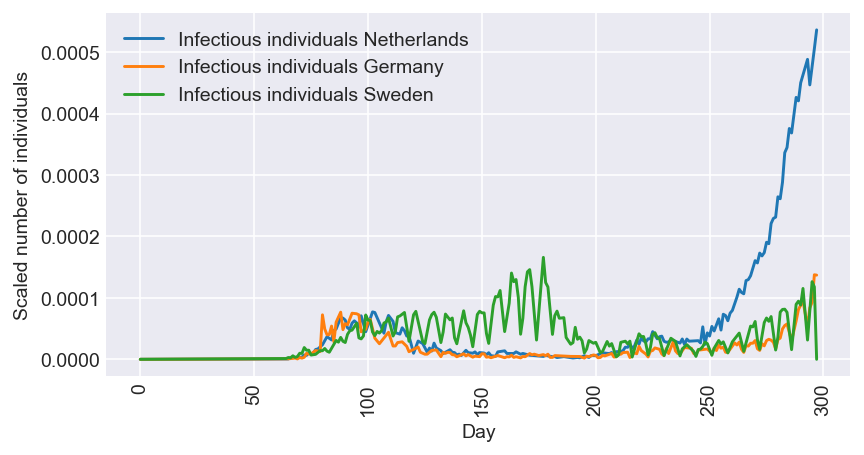

In [3]:
df = pd.read_csv("./data/download")

def get_country(df, countryname):
    """
    Get the dataframe per country
    """
    df = df[df['countriesAndTerritories']==countryname]
    df = df.reindex(index=df.index[::-1])
    df = df.set_index('dateRep')
    df.index = pd.to_datetime(df.index,format='%d/%m/%Y')

    return df 

def plot_country(country,countryname,population):
    """
    Plot infectious individuals per capita
    """
    cases = [i/population for i in country['cases']]
    plt.plot(cases,label='Infectious individuals '+str(countryname))

    plt.ylabel('Scaled number of individuals')
    plt.xlabel('Day')
    plt.xticks(rotation=90)
    plt.legend()

# Define total populations 
pop_nl = 17280000
pop_germ = 82.02*10**6
pop_sw = 10.23*10**6

my_dpi=140
plt.figure(figsize=(960/my_dpi, 480/my_dpi), dpi=my_dpi)

# Get dataframes 
nl = get_country(df, 'Netherlands')
germ = get_country(df, 'Germany')
sw = get_country(df, 'Sweden')

# Plot countries
plot_country(nl,'Netherlands',pop_nl)
plot_country(germ,'Germany',pop_germ)
plot_country(sw,'Sweden',pop_sw)

Sweden:
beta gamma: [6.80304128 6.74368786] found after fitting


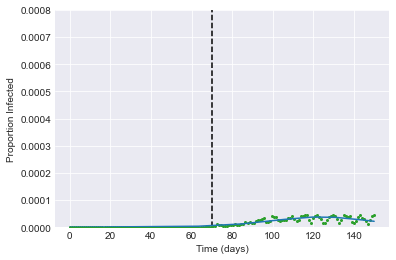

beta gamma: [5.33175602 5.281665  ] found after fitting


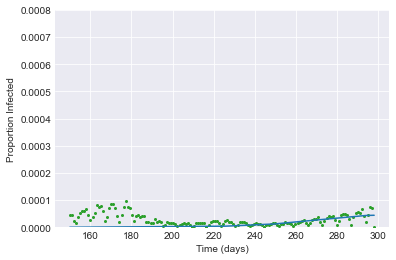

---------------------
Germany:
beta gamma: [4.38234447 4.2786114 ] found after fitting


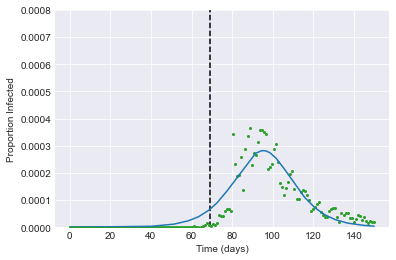

beta gamma: [1.01135625 0.93839892] found after fitting


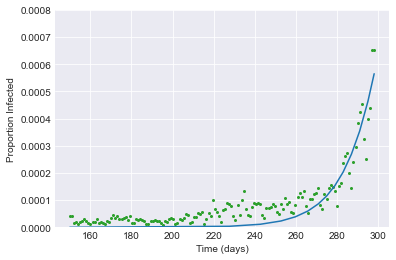

---------------------
Netherlands
beta gamma: [7.45562114 7.37334276] found after fitting


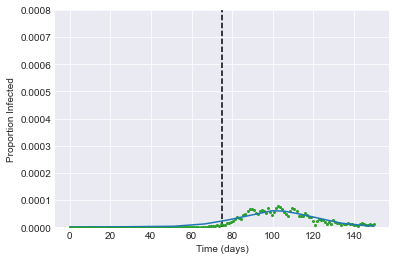

beta gamma: [1.87115468 1.80469025] found after fitting


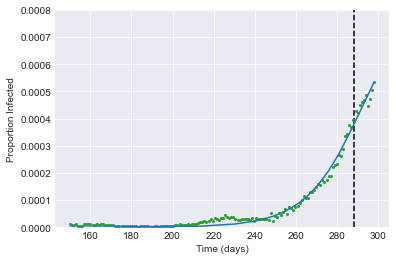

---------------------


In [13]:
def SIR(y,t,beta,gamma):
    '''
    Ordinary Differential Equations of the basic SIR model
    '''
    S0,I0,R0 = y
    dSdt = - beta * S0 * I0
    dIdt = beta * S0 * I0 - gamma * I0
    dRdt = gamma * I0   
    return [dSdt, dIdt, dRdt] 


def get_cases(country=nl,citizens=17280000):
    '''
    Return proportional cases of infectious individuals 
    '''
    # Convert experimental numbers to proportions
    number = [i for i in country['cases']]
    # prop = [i/(17*10**6) for i in number]
    prop = [i/citizens for i in number]

    return prop

def plot_cases_sir(beta_guess,prop,lockdown,population_size,country,plot=True,
                   timepoint1=0,timepoint2=150):   
    """
    Plot the dynamics of the infectious individuals fitted on real data per country. 
    Parameters: 
    ----------------
    beta_guess: guessed beta values for initiating the ODR 
    prop: proportion of the population that is infectious
    lockdown: start day of the lockdown, e.g. X days after 31st December 2019 when lockdown started
    population_size: total population size
    beta: Transmission rate (day^-1)
    gamma: Recovery rate 1/gamma days 
    country: name of 
    """
   
    def solveODEs(param,t):
        """Solves differential equations"""
        beta,gamma = param

         # define differential equations
        def SIR(y_0, t):
            """The Ordinary Differential Equations for the basic SIR model"""
            dSdt = - beta * y_0[0] * y_0[1]
            dIdt = beta * y_0[0] * y_0[1] - gamma * y_0[1]
            dRdt = gamma * y_0[1]
            return [dSdt, dIdt, dRdt] 

        return odeint(SIR, y_0, t)[:,1]

    # Times at which the solution is to be computed
    t = np.linspace(timepoint1,timepoint2,timepoint2-timepoint1)

    # Create a Data object using our initiated data from above.
    data = Data(t, prop) 

    # Define initial conditions
    I_0 = 1/population_size
    R_0 = 0.0
    S_0 = 1
    y_0 = [S_0, I_0, R_0]

    # Store information of solveODEs function 
    model = Model(solveODEs) 
    # # Set up ODR with the model, data and initial parameter estimate.
    odr = ODR(data, model, beta0=beta_guess) 
    # # Run the regression
    out = odr.run() 
    beta,gamma=out.beta

    print("beta gamma: {} found after fitting".format(out.beta))
#     print("Standard deviations found after fitting: {}".format(out.sd_beta))

    if plot: 
        #Plot proportion infected over time 
#         plt.figure(figsize=(960/my_dpi, 480/my_dpi), dpi=my_dpi)
        plt.plot(t, prop,'ro',color='tab:green',markersize=2)
        plt.plot(t, solveODEs((beta,gamma),t),color='tab:blue',markersize=10)
        plt.xlabel('Time (days)')
        plt.ylabel('Proportion Infected')
        plt.grid(True)
        if lockdown: 
            plt.vlines(lockdown,0,0.0008,color='black',linestyle='dashed')
        plt.ylim(0,0.0008)
#         plt.savefig('/Users/zaidarivai/Desktop/naamloze map 2/intro-project-sir/figures/'+str(country)+str(timepoint2))
        plt.show()

#Determine beta and gamma values during peak 
# Plot for Sweden separetely
print("Sweden:")
propsw = get_cases(sw)
plot_cases_sir(prop=propsw[:150],population=pop_sw,lockdown=70,population_size=pop_sw,country='Sweden',
              beta_guess=[1, 0.8])
plot_cases_sir(timepoint1=150,timepoint2=len(germ),
               beta_guess=[.9, .8],prop=propsw[150:len(sw)],
               population=pop_germ,lockdown=np.nan,population_size=pop_sw,country='Sweden')
print('---------------------')

# Plot for Germany separetely
print("Germany:")
propgerm = get_cases(germ)
plot_cases_sir(prop=propgerm[:150],population=pop_germ,lockdown=69,population_size=pop_germ,country='Germany',
              beta_guess=[1, 0.8])
plot_cases_sir(timepoint1=150,timepoint2=len(germ),
               beta_guess=[.9, .8],prop=propgerm[150:len(germ)],
               population=pop_germ,lockdown=np.nan,population_size=pop_germ,country='Germany')
print('---------------------')

print('Netherlands')
# Plot for the Netherlands separetely
propnl = get_cases()
plot_cases_sir(prop=propnl[:150],timepoint1=0,timepoint2=150,beta_guess=[1, 0.8],population=pop_nl,
                  lockdown=75,population_size=pop_nl,plot=True,country='Netherlands')
plot_cases_sir(timepoint1=150,timepoint2=len(nl),beta_guess=[.9, .5],prop=propnl[150:len(nl)],lockdown=288,
              population=pop_nl,population_size=pop_nl,country='Netherlands')
print('---------------------')


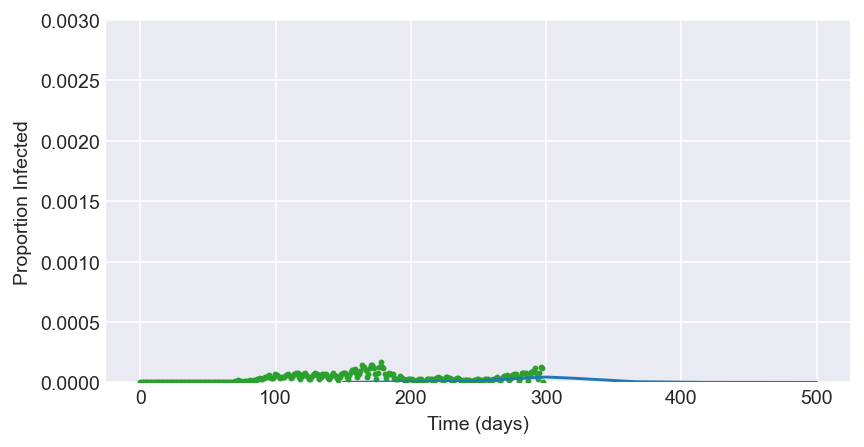

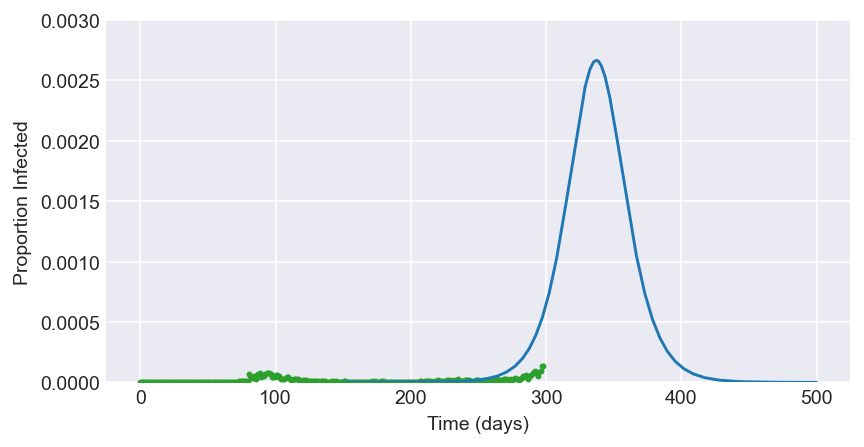

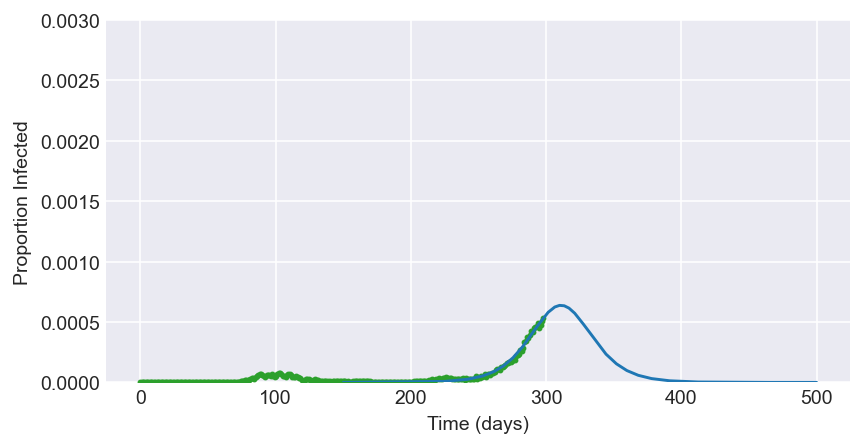

In [138]:
def get_cases(citizens,country):
    '''
    Return proportional cases of infectious individuals 
    '''
    # Convert experimental numbers to proportions
    number = [i for i in country['cases']]
    # prop = [i/(17*10**6) for i in number]
    prop = [i/citizens for i in number]

    return prop

def predict_cases(population_total, proportions, beta, gamma):
    """
    Plot predictions of the infectious individuals. 
    
    Parameters: 
    ----------------
    population_total: Total population 
    proportions: Proportion of infectious individuals 
    beta: Transmission rate (day^-1)
    gamma: Recovery rate 1/gamma days 
    """
    def solveODEs(param,t):
            """Solves differential equations"""
            beta,gamma = param

             # define differential equations
            def SIR(y_0, t):
                """The Ordinary Differential Equations for the basic SIR model"""
                dSdt = - beta * y_0[0] * y_0[1]
                dIdt = beta * y_0[0] * y_0[1] - gamma * y_0[1]
                dRdt = gamma * y_0[1]
                return [dSdt, dIdt, dRdt] 

            return odeint(SIR, y_0, t)[:,1]

    # Times at which the solution is to be computed
    t = np.linspace(0,298,298)
    t2 = np.linspace(150,500,500)

    # Define initial conditions
    I_0 = 1/population_total
    R_0 = 0.0
    S_0 = 1
    y_0 = [S_0, I_0, R_0]

    #Plot proportion infected over time 
    plt.figure(figsize=(960/my_dpi, 480/my_dpi), dpi=my_dpi)
    plt.plot(t, proportions,'ro',color='tab:green',markersize=2)
    plt.plot(t2, solveODEs((beta,gamma),t2),color='tab:blue',markersize=10)
    plt.xlabel('Time (days)')
    plt.ylabel('Proportion Infected')
    plt.grid(True)
    plt.ylim(0,0.0030)
    plt.xticks()
    #         plt.savefig('/Users/zaidarivai/Desktop/naamloze map 2/intro-project-sir/figures/'+str(country)+str(timepoint2))
    plt.show()

#Sweden second 150 days: 
beta_s,gamma_s=5.33175602, 5.281665

#Germany second 150 days: 
beta_g,gamma_g = 1.01135625, 0.93839892
#Netherlands second 150 days: 
beta_nl, gamma_nl = 1.87115468, 1.80469025

# Get total population numbers per country
pop_nl = 17280000
pop_germ = 82.02*10**6
pop_sw = 10.23*10**6

# Get infectious proportions per country
proportions_sw = get_cases(pop_sw,sw)
proportions_germ = get_cases(pop_germ,germ)
proportions_nl = get_cases(pop_nl,nl)

predict_cases(population_total=pop_sw, proportions=proportions_sw, beta=beta_s,gamma=gamma_s)
predict_cases(population_total=pop_germ, proportions=proportions_germ, beta=beta_g,gamma=gamma_g)
predict_cases(population_total=pop_nl, proportions=proportions_nl, beta=beta_nl,gamma=gamma_nl)

    

In [51]:
# data_loader = cs.DataLoader("input")
# jhu_data = data_loader.jhu()
# japan_data = data_loader.japan()
# pop_data = data_loader.population()
# oxcgrt_data = data_loader.oxcgrt()

In [7]:
# Show dataset
_out_df = df.copy()
_out_df

out_df = df.copy()
out_df

,dateRep,day,month,year,cases,deaths,countriesAndTerritories,geoId,countryterritoryCode,popData2019,continentExp,Cumulative_number_for_14_days_of_COVID-19_cases_per_100000
0,23/10/2020,23,10,2020,116,4,Afghanistan,AF,AFG,38041757.0,Asia,2.452568
1,22/10/2020,22,10,2020,135,2,Afghanistan,AF,AFG,38041757.0,Asia,2.350049
2,21/10/2020,21,10,2020,88,2,Afghanistan,AF,AFG,38041757.0,Asia,2.173927
3,20/10/2020,20,10,2020,87,5,Afghanistan,AF,AFG,38041757.0,Asia,2.105581
4,19/10/2020,19,10,2020,59,4,Afghanistan,AF,AFG,38041757.0,Asia,2.258045
...,...,...,...,...,...,...,...,...,...,...,...,...
50827,25/03/2020,25,3,2020,0,0,Zimbabwe,ZW,ZWE,14645473.0,Africa,NaN
50828,24/03/2020,24,3,2020,0,1,Zimbabwe,ZW,ZWE,14645473.0,Africa,NaN
50829,23/03/2020,23,3,2020,0,0,Zimbabwe,ZW,ZWE,14645473.0,Africa,NaN
50830,22/03/2020,22,3,2020,1,0,Zimbabwe,ZW,ZWE,14645473.0,Africa,NaN


## Population pyramid

In [16]:
pyramid_csv_list = list()
for dirname, _, filenames in os.walk("./data/countrydata/"):
    print(filenames)
    for filename in filenames:
        name = os.path.join(dirname, filename)
        df = pd.read_csv(name)
        df["Country"], df["Year"], _ = filename.replace(".", "-").split("-")
        pyramid_csv_list.append(df)
        print(pyramid_csv_list)
pyramid_raw = pd.concat(pyramid_csv_list, sort=True)
pyramid_raw.head()

['Sweden-2019.csv', 'Germany-2019.csv', 'Netherlands-2019.csv']
[      Age       M       F Country  Year
0     0-4  307116  290553  Sweden  2019
1     5-9  304759  288817  Sweden  2019
2   10-14  296771  280944  Sweden  2019
3   15-19  270840  257677  Sweden  2019
4   20-24  291723  274760  Sweden  2019
5   25-29  376952  361526  Sweden  2019
6   30-34  343311  330153  Sweden  2019
7   35-39  315086  300752  Sweden  2019
8   40-44  312017  301288  Sweden  2019
9   45-49  336452  327453  Sweden  2019
10  50-54  342117  331458  Sweden  2019
11  55-59  306949  300084  Sweden  2019
12  60-64  279609  280009  Sweden  2019
13  65-69  265511  272149  Sweden  2019
14  70-74  273061  286879  Sweden  2019
15  75-79  195029  212480  Sweden  2019
16  80-84  113166  143654  Sweden  2019
17  85-89   61775   97633  Sweden  2019
18  90-94   26170   52624  Sweden  2019
19  95-99    6768   18130  Sweden  2019
20   100+     415    1771  Sweden  2019]
[      Age       M       F Country  Year
0     0-4  30

,Age,Country,F,M,Year
0,0-4,Sweden,290553,307116,2019
1,5-9,Sweden,288817,304759,2019
2,10-14,Sweden,280944,296771,2019
3,15-19,Sweden,257677,270840,2019
4,20-24,Sweden,274760,291723,2019


In [17]:
pyramid_raw["Country"].unique()

array(['Sweden', 'Germany', 'Netherlands'], dtype=object)

In [18]:
df = pyramid_raw.copy()
df["Country"] = df["Country"].replace(
    {
        "United States of America": "US",
        "United Kingdom": "UK",
    }
)
# Global (WORLD)
_male = [
    349432556, 342927576, 331497486, 316642222, 308286775, 306059387, 309236984,
    276447037, 249389688, 241232876, 222609691, 192215395, 157180267, 128939392,
    87185982, 54754941, 33648953, 15756942, 5327866, 1077791, 124144
]
_female = [
    328509234, 321511867, 309769906, 295553758, 289100903, 288632766, 296293748,
    268371754, 244399176, 238133281, 223162982, 195633743, 164961323, 140704320,
    101491347, 69026831, 48281201, 26429329, 11352182, 3055845, 449279
]
_df = pd.DataFrame(
    {
        "Age": df["Age"].unique(),
        "Country": "Global",
        "F": _female,
        "M": _male,
        "Year": 2019
    }
)
df = pd.concat([df, _df], axis=0, ignore_index=True, sort=True)
# Sweden
_male = [
    307116, 304759, 296771, 270840, 291723, 376952, 343311, 315086,
    312017, 336452, 342117, 306949, 279609, 265511, 273061, 195029,
    113166, 61775, 26170, 6768, 415
]
_female = [
    290553, 288817, 280944, 257677, 274760, 361526, 330153, 300752,
    301288, 327453, 331458, 300084, 280009, 272149, 286879, 212480,
    143654, 97633, 52624, 18130, 1771
]
_df = pd.DataFrame(
    {
        "Age": df["Age"].unique(),
        "Country": "Sweden",
        "F": _female,
        "M": _male,
        "Year": 2019
    }
)
df = pd.concat([df, _df], axis=0, ignore_index=True, sort=True)
# Netherlands
_male = [
    5534962, 5820604, 5538414, 5383822, 5149849, 4710777, 4061897, 3581091, 3237426,
    2832825, 2482953, 2015857, 1556935, 1082875, 668107, 364200, 199400, 73508,
    17327, 3035, 208
]
_female = [
    5240508, 5541514, 5273495, 5029137, 4896316, 4589506, 3982681,
    3544279, 3191565, 2825286, 2521463, 2112380, 1714689, 1285782,
    895866, 567282, 360751, 155294, 57969, 13376, 1411
]
_df = pd.DataFrame(
    {
        "Age": df["Age"].unique(),
        "Country": "Netherlands",
        "F": _female,
        "M": _male,
        "Year": 2019
    }
)
df = pd.concat([df, _df], axis=0, ignore_index=True, sort=True)
# Arrange
df["Population"] = df["F"] + df["M"]
df = df.pivot_table(
    index="Age", columns=["Country"], values="Population", aggfunc="last"
)
df = df.astype(np.int64).reset_index().rename({"Age": "Age_bin"}, axis=1)
series = df["Age_bin"].str.replace("+", "-122")
df[["Age_first", "Age_last"]] = series.str.split("-", expand=True).astype(np.int64)
df = df.drop("Age_bin", axis=1)
series = df["Age_last"]
df = df.apply(lambda x: x[:-2] / (x[-1] - x[-2] + 1), axis=1)
df["Age"] = series
df = pd.merge(df, pd.DataFrame({"Age": np.arange(0, 123, 1)}), on="Age", how="right", sort=True)
df = df.fillna(method="bfill").astype(np.int64)
df = df.set_index("Age")
pyramid_df = df.copy()
pyramid_df

,Germany,Global,Netherlands,Sweden
Age,,,,
0,797488,135588358,2155094,119533
1,797488,135588358,2155094,119533
2,797488,135588358,2155094,119533
3,797488,135588358,2155094,119533
4,797488,135588358,2155094,119533
...,...,...,...,...
118,769,24931,70,95
119,769,24931,70,95
120,769,24931,70,95


In [19]:
df = pyramid_df.cumsum()
countries = df.columns[:]
df = pd.merge(_out_df, df, left_on="Age_last", right_on="Age", how="left")
_first = df.loc[df.index[0], countries]
df[countries] = df[countries].diff()
df.loc[df.index[0], countries] = _first
df[countries] = df[countries].apply(lambda x: x / x.sum(), axis=0)
out_df = df.copy()
out_df

KeyError: 'Age_last'

In [20]:
def go_out(country, out_df=out_df):
    """
    Return the estimated number of days people usually go out.
    @country <str>: coutry name
    @out_df <pd.DataFrame>: template dataframe
    """
    df = out_df.copy()
    try:
        series = df[country]
    except KeyError:
        raise KeyError(f"Population pyramid data of {country} is not defined!")
    df = df.iloc[:, :6]
    df["Portion"] = series
    return df

### SIR model

#### SIR-D model

SIR
{'step_n': 180, 'population': 1000000, 'param_dict': {'rho': 0.2, 'sigma': 0.075}, 'y0_dict': {'Susceptible': 999000, 'Infected': 1000, 'Fatal or Recovered': 0}}


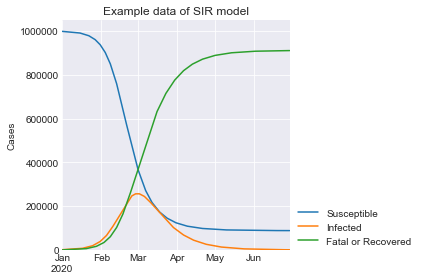

xmax: 	 0.366211 
1/RO: 	0.37453183520599254
preset_dict {'theta': 0.002, 'kappa': 0.005, 'rho': 0.2, 'sigma': 0.075}
pop_data <covsirphy.cleaning.population.PopulationData object at 0x7ff4e37f1d50>


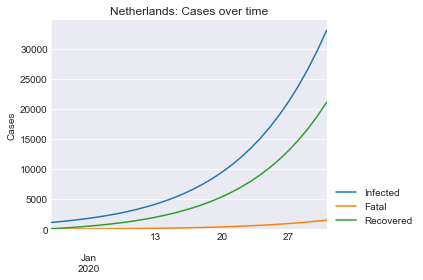

,Date,Confirmed,Infected,Fatal,Recovered
0,2020-01-02,1213,1127,6,80
1,2020-01-03,1451,1270,12,169
2,2020-01-04,1720,1430,19,271
3,2020-01-05,2025,1612,28,385
4,2020-01-06,2366,1816,37,513


,Date,Confirmed,Infected,Fatal,Recovered
25,2020-01-27,35218,21210,940,13068
26,2020-01-28,39544,23730,1061,14753
27,2020-01-29,44357,26524,1196,16637
28,2020-01-30,49704,29616,1347,18741
29,2020-01-31,55633,33030,1515,21088


rho_before actions taken 0.2


KeyError: 'Population pyramid data of Netherlands is not defined!'

In [31]:
# Set tau value and start date of records
# For explanation, the start date will be 01Jan2020
# This is not based on actual data
example_data = cs.ExampleData(tau=1440, start_date="01Jan2020")
# No records has been registered
example_data.cleaned()

# Model name
print(cs.SIR.NAME)
# Example parameter values
print(cs.SIR.EXAMPLE)

model = cs.SIR
area = {"country": "Full", "province": model.NAME}
# Add records with SIR model
example_data.add(model, **area)
# Records with model variables
df = example_data.specialized(model, **area)
cs.line_plot(
    df.set_index("Date"),
    title=f"Example data of {model.NAME} model",
    y_integer=True
)

# define R0
eg_r0 = model(model.EXAMPLE["population"], **model.EXAMPLE["param_dict"]).calc_r0()
df = example_data.specialized(model, **area)

# define Xmax
x_max = df.loc[df["Infected"].idxmax(), "Susceptible"] / cs.SIR.EXAMPLE["population"]

print('xmax: \t {} \n1/RO: \t{}'.format(x_max, 1/eg_r0))

# Preset of SIR-F parameters
preset_dict = cs.SIRF.EXAMPLE["param_dict"]
print('preset_dict',preset_dict)

area = {"country": "Netherlands"}
# Create dataset from 01Jan2020 to 31Jan2020
example_data.add(cs.SIRF, step_n=30, **area)

# Set population value
pop_data.update(cs.SIRF.EXAMPLE["population"], **area)
pop_data.value(**area)

# # Register population value
pop_data.update(cs.SIRF.EXAMPLE["population"], **area)
pop_data.value(**area)

# example_data
print('pop_data',pop_data)

# Show records with Scenario class
snl = cs.Scenario(example_data, pop_data, tau=1440,**area)
record_df = snl.records()
display(record_df.head())
display(record_df.tail())

# Value of beta before actions are taken
rho_before = cs.SIRF.EXAMPLE["param_dict"]["rho"]
print('rho_before actions taken',rho_before)

eg_out_df = go_out("Netherlands")
print('eg_out_df',eg_out_df)

gs_before = (eg_out_df[["School", "Office", "Others"]].sum(axis=1) * eg_out_df["Portion"]).sum()
print('gs_before',gs_before)


In [32]:
def go_out(country, out_df=out_df):
    """
    Return the estimated number of days people usually go out.
    @country <str>: coutry name
    @out_df <pd.DataFrame>: template dataframe
    """
    df = out_df.copy()
    try:
        series = df[country]
    except KeyError:
        raise KeyError(f"Population pyramid data of {country} is not defined!")
    df = df.iloc[:, :6]
    df["Portion"] = series
    return df

go_out("Global")

KeyError: 'Population pyramid data of Global is not defined!'

In [333]:
# Set 0th phase from 02Jan2020 to 31Jan2020 with preset parameter values
snl.clear(include_past=True)
snl.add(end_date="31Jan2020", model=cs.SIRF, **preset_dict)
snl.summary()
# Add main scenario: the same parameter to 31Dec2020
snl.add(end_date="31Dec2020", name="Main")
# Add lockdown scenario
snl.clear(include_past=False, name="Lockdown")
snl.add(end_date="31Dec2020", name="Lockdown", rho=rho_after).summary()

NameError: name 'rho_after' is not defined